In [2]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
target = 'net_target+1'

In [43]:
power = pd.read_csv('debug_logs/real_power_gurobi_step_leap_1_forecast_step_3.csv')
power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
power = power.sort_values(by=['time_step', 'building'])
power['building'] = power['building'].str[-1].astype(int)
power = power[power['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(24)]
# upload min-max scaler from scalers folders with .save extension
scalers = [joblib.load(f'scalers/scaler_net_{k}.save') for k in range(1, 6)]
power_norm = pd.DataFrame()
for building in range(5):
    power_norm_temp = pd.DataFrame()
    power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
    power_norm_temp['building'] = building
    power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
    power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
power_norm = power_norm.dropna()
power_norm = power_norm.sort_values(by=['time_step', 'building'])
# drop the net_target column
power_norm = power_norm.drop(columns=['net_target'])
# set the index to time_step and building
power_norm = power_norm.set_index(['time_step', 'building'])
power_norm['Hour'] = power_norm.index.get_level_values(0) % 24
cols = power_norm.columns.tolist()
cols = cols[-1:] + cols[:-1]
power_norm = power_norm[cols]
power_norm

Hour  net_target+0  net_target+1  net_target+2  \
time_step building                                                   
0         0            0  8.511667e-01  8.346000e-01  8.381667e-01   
          1            0  1.370667e+00  1.101250e+00  5.432167e-01   
          2            0  1.018524e-07  1.008352e-07  1.007080e-07   
          3            0  1.928167e+00  4.758167e-01  4.582333e-01   
          4            0  5.158833e-01  5.030500e-01  5.359500e-01   
...                  ...           ...           ...           ...   
8735      0           23  1.581708e+00  5.796833e-01  5.926500e-01   
          1           23  2.289758e+00  5.151167e-01  7.532500e-01   
          2           23  7.067500e-01  4.349000e-01  4.231333e-01   
          3           23  3.510683e+00  2.099967e+00  2.567050e+00   
          4           23  1.343600e+00  9.951167e-01  9.510333e-01   

                    net_target+3  net_target+4  net_target+5  net_target+6  \
time_step building                                                           
0         0         1.478433e+00  1.256200e+00      1.811500      0.362733   
          1         5.428333e-01  1.512433e+00      0.326250      0.560617   
          2         1.015981e-07  9.943644e-08     -0.027283     -0.136700   
          3         4.460167e-01  4.658833e-01      0.637133      0.698950   
          4         5.126167e-01  3.032167e-01      0.378583      0.274750   
...                          ...           ...           ...           ...   
8735      0         5.763333e-01  5.861833e-01      0.590600      0.770317   
          1         7.767167e-01  1.895200e+00      0.350383      0.319250   
          2         4.464667e-01  3.864667e-01      0.377350      0.314100   
          3         5.842667e-01  7.306833e-01      1.942067      0.466517   
          4         6.088167e-01  5.943000e-01      0.376467      0.444233   

                    net_target+7  net_target+8  ...  net_target+14  \
time_step building                              ...                  
0         0            -0.489917     -1.184867  ...      -0.595117   
          1             1.119483      0.750300  ...       0.935333   
          2            -0.034533     -0.870133  ...      -1.413883   
          3             2.152567      1.689017  ...      -1.972850   
          4            -0.070083     -0.254483  ...      -0.109050   
...                          ...           ...  ...            ...   
8735      0             0.220983     -0.395883  ...      -0.199817   
          1             0.222683      0.344467  ...       0.944117   
          2             0.235600     -0.065217  ...      -1.414011   
          3             0.851900      2.077183  ...       0.192433   
          4            -0.149983     -0.809817  ...       0.522200   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0             -0.298267       0.059700       1.054850   
          1              0.204017      -0.572450      -0.678733   
          2             -1.743550      -1.656633      -0.879733   
          3             -2.074017      -0.055433       0.160417   
          4             -0.137150       0.023717       2.313683   
...                           ...            ...            ...   
8735      0              0.115850       0.803650       2.636517   
          1              1.083967      -1.310933      -1.106450   
          2             -0.635250      -0.525617       0.284317   
          3             -0.329417       0.222217       1.017867   
          4              1.169617       1.663533       3.119600   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0              1.006983   3.603983e+00   5.008500e+00   
          1             -0.069417   3.583334e-01   1.584500e+00   
          2             -0.045600   1.01184

In [44]:
forecs = pd.read_csv('debug_logs/scen_gurobi_phase_1_step_leap_1_forecast_step_1.csv')
# drop scenario column 
forecs = forecs.drop(columns=['scenario'])
forecs = forecs.set_index(['time_step', 'building'])
forecs['Hour'] = forecs.index.get_level_values(0) % 24
# move hour column to the first position
cols = forecs.columns.tolist()
cols = cols[-1:] + cols[:-1]
forecs = forecs[cols]
forecs

Hour       +0h       +1h       +2h       +3h       +4h  \
time_step building                                                           
0         0            0  1.315463  0.997405  0.882386  0.827967  0.815308   
          1            0  1.250480  0.990671  0.878696  0.825506  0.813198   
          2            0  0.334184  0.505538  0.559403  0.592007  0.637254   
          3            0  1.501574  1.066869  0.904937  0.844253  0.837024   
          4            0  0.761706  0.742030  0.697915  0.701616  0.719273   
...                  ...       ...       ...       ...       ...       ...   
8759      0           23  1.669145  0.967867  0.877480  0.929736  0.935463   
          1           23  2.245950  1.931647  1.289904  0.990013  0.751804   
          2           23  0.975433  0.663972  0.611254  0.637533  0.561356   
          3           23  2.254037  2.350549  1.485572  1.346622  1.352428   
          4           23  1.187051  0.964607  0.755980  0.710703  0.584266   

                         +5h       +6h       +7h       +8h  ...      +14h  \
time_step building                                          ...             
0         0         0.853358  0.710826  0.255466 -0.147608  ... -0.335835   
          1         0.851392  0.709265  0.254513 -0.148373  ... -0.340026   
          2         0.685898  0.604959  0.175989 -0.205084  ... -0.341320   
          3         0.860239  0.655470  0.086987 -0.439690  ... -0.742460   
          4         0.756398  0.633275  0.210226 -0.174398  ... -0.350937   
...                      ...       ...       ...       ...  ...       ...   
8759      0         1.051124  1.248356  1.070367  0.122231  ... -1.032682   
          1         0.593789  0.528411  0.752680  0.387571  ...  0.035232   
          2         0.561906  0.657419  0.700056  0.266056  ... -0.811553   
          3         1.242820  1.089822  1.479045  1.236717  ...  0.504712   
          4         0.539956  0.553974  0.229366 -0.553871  ...  0.802364   

                        +15h      +16h      +17h      +18h      +19h  \
time_step building                                                     
0         0         0.450289  0.835517  1.262387  1.473747  1.314026   
          1         0.449820  0.834876  1.261625  1.473639  1.312518   
          2         0.449186  0.798859  1.208564  1.391791  1.241544   
          3         0.219726  0.673009  1.202868  1.476299  1.326355   
          4         0.439368  0.792496  1.234261  1.410800  1.273827   
...                      ...       ...       ...       ...       ...   
8759      0        -0.577529  0.007843  1.208888  2.519401  2.931290   
          1         0.240522  0.254429  0.254242  0.614973  1.398581   
          2        -0.447578 -0.221324  0.060082  0.393557  1.379672   
          3         0.543498  0.609336  1.096179  1.867624  2.589513   
          4         1.168235  1.685556  2.192099  2.746798  2.335720   

                        +20h      +21h      +22h      +23h  
time_step building                                          
0         0         1.357523  1.363334  1.404195  1.280302  
          1         1.356081  1.361599  1.401595  1.275230  
          2         1.262507  1.228239  1.160263  0.833793  
          3         1.377343  1.370731  1.424389  1.315757  
          4         1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...  
8759      0         2.964769  2.673315  2.317424  1.999848  
          1         1.140973  1.190661  1.388406  1.838529  
          2         1.223565  1.117971  1.134075  1.191572  
          3         1.387635  1.605515  2.018991  2.392163  
          4         1.101535  1.073346  1.523081  1.517886  

[43800 rows x 25 columns]

In [45]:
# keep pnly indexes matching the forecs
forecs_ltd = forecs.loc[power_norm.index]
forecs_ltd

Hour       +0h       +1h       +2h       +3h       +4h  \
time_step building                                                           
0         0            0  1.315463  0.997405  0.882386  0.827967  0.815308   
          1            0  1.250480  0.990671  0.878696  0.825506  0.813198   
          2            0  0.334184  0.505538  0.559403  0.592007  0.637254   
          3            0  1.501574  1.066869  0.904937  0.844253  0.837024   
          4            0  0.761706  0.742030  0.697915  0.701616  0.719273   
...                  ...       ...       ...       ...       ...       ...   
8735      0           23  1.307816  0.833908  0.826822  0.847069  0.880363   
          1           23  2.570450  1.973022  1.362084  0.960358  0.786632   
          2           23  0.745470  0.747448  0.673948  0.612527  0.557501   
          3           23  2.593832  2.054581  1.394668  1.206103  1.265229   
          4           23  1.120894  0.867890  0.747074  0.649337  0.580665   

                         +5h       +6h       +7h       +8h  ...      +14h  \
time_step building                                          ...             
0         0         0.853358  0.710826  0.255466 -0.147608  ... -0.335835   
          1         0.851392  0.709265  0.254513 -0.148373  ... -0.340026   
          2         0.685898  0.604959  0.175989 -0.205084  ... -0.341320   
          3         0.860239  0.655470  0.086987 -0.439690  ... -0.742460   
          4         0.756398  0.633275  0.210226 -0.174398  ... -0.350937   
...                      ...       ...       ...       ...  ...       ...   
8735      0         1.077949  1.134726  0.692751 -0.074943  ... -1.150679   
          1         0.642956  0.522123  0.570573  0.387960  ... -0.171781   
          2         0.604905  0.643514  0.509708  0.223648  ... -1.042489   
          3         1.294757  1.034027  1.247875  1.221969  ...  0.081814   
          4         0.561168  0.390262 -0.180341 -0.865624  ...  0.437932   

                        +15h      +16h      +17h      +18h      +19h  \
time_step building                                                     
0         0         0.450289  0.835517  1.262387  1.473747  1.314026   
          1         0.449820  0.834876  1.261625  1.473639  1.312518   
          2         0.449186  0.798859  1.208564  1.391791  1.241544   
          3         0.219726  0.673009  1.202868  1.476299  1.326355   
          4         0.439368  0.792496  1.234261  1.410800  1.273827   
...                      ...       ...       ...       ...       ...   
8735      0        -0.744115 -0.006555  1.370029  2.497657  2.803609   
          1         0.067596 -0.027369  0.308757  0.668974  1.427968   
          2        -0.650426 -0.405748  0.204797  0.520217  1.333799   
          3         0.357500  0.404472  1.194380  1.930412  2.483089   
          4         0.896024  1.603932  2.363738  2.783216  2.326213   

                        +20h      +21h      +22h      +23h  
time_step building                                          
0         0         1.357523  1.363334  1.404195  1.280302  
          1         1.356081  1.361599  1.401595  1.275230  
          2         1.262507  1.228239  1.160263  0.833793  
          3         1.377343  1.370731  1.424389  1.315757  
          4         1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...  
8735      0         2.987715  2.751516  2.375428  1.927582  
          1         1.181158  1.294230  1.402610  1.942418  
          2         1.249528  1.178516  1.129053  1.155793  
          3         1.357712  1.605706  2.051101  2.274746  
          4         1.121863  1.145607  1.538900  1.463096  

[43680 rows x 25 columns]

In [51]:
errors = np.array(power_norm.iloc[:, 1:]) - np.array(forecs_ltd.iloc[:, 1:])
errors_df = pd.DataFrame(errors, columns=power_norm.columns[1:], index=power_norm.index)
errors_df['Hour'] = errors_df.index.get_level_values(0) % 24
cols = errors_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
errors_df = errors_df[cols]
errors_df

Hour  net_target+0  net_target+1  net_target+2  \
time_step building                                                   
0         0            0     -0.464296     -0.162805     -0.044219   
          1            0      0.120187      0.110579     -0.335480   
          2            0     -0.334184     -0.505538     -0.559403   
          3            0      0.426593     -0.591053     -0.446703   
          4            0     -0.245822     -0.238980     -0.161965   
...                  ...           ...           ...           ...   
8735      0           23      0.273892     -0.254224     -0.234172   
          1           23     -0.280692     -1.457906     -0.608834   
          2           23     -0.038720     -0.312548     -0.250815   
          3           23      0.916851      0.045385      1.172382   
          4           23      0.222706      0.127227      0.203960   

                    net_target+3  net_target+4  net_target+5  net_target+6  \
time_step building                                                           
0         0             0.650466      0.440892      0.958142     -0.348093   
          1            -0.282673      0.699236     -0.525142     -0.148648   
          2            -0.592007     -0.637254     -0.713182     -0.741659   
          3            -0.398237     -0.371141     -0.223105      0.043480   
          4            -0.188999     -0.416056     -0.377815     -0.358525   
...                          ...           ...           ...           ...   
8735      0            -0.270735     -0.294179     -0.487349     -0.364409   
          1            -0.183641      1.108568     -0.292572     -0.202873   
          2            -0.166060     -0.171034     -0.227555     -0.329414   
          3            -0.621837     -0.534546      0.647310     -0.567510   
          4            -0.040520      0.013635     -0.184701      0.053972   

                    net_target+7  net_target+8  ...  net_target+14  \
time_step building                              ...                  
0         0            -0.745383     -1.037259  ...      -0.259282   
          1             0.864970      0.898673  ...       1.275359   
          2            -0.210522     -0.665049  ...      -1.072564   
          3             2.065580      2.128707  ...      -1.230390   
          4            -0.280309     -0.080085  ...       0.241887   
...                          ...           ...  ...            ...   
8735      0            -0.471768     -0.320940  ...       0.950863   
          1            -0.347889     -0.043493  ...       1.115897   
          2            -0.274108     -0.288865  ...      -0.371522   
          3            -0.395975      0.855214  ...       0.110619   
          4             0.030357      0.055807  ...       0.084268   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0             -0.748556      -0.775817      -0.207537   
          1             -0.245804      -1.407326      -1.940358   
          2             -2.192736      -2.455492      -2.088297   
          3             -2.293743      -0.728443      -1.042452   
          4             -0.576518      -0.768779       1.079422   
...                           ...            ...            ...   
8735      0              0.859965       0.810205       1.266488   
          1              1.016370      -1.283564      -1.415207   
          2              0.015176      -0.119868       0.079520   
          3             -0.686917      -0.182255      -0.176514   
          4              0.273592       0.059601       0.755862   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0             -0.466763       2.289957       3.650977   
          1             -1.543055      -0.954185       0.228419   
          2             -1.437391      -1.2

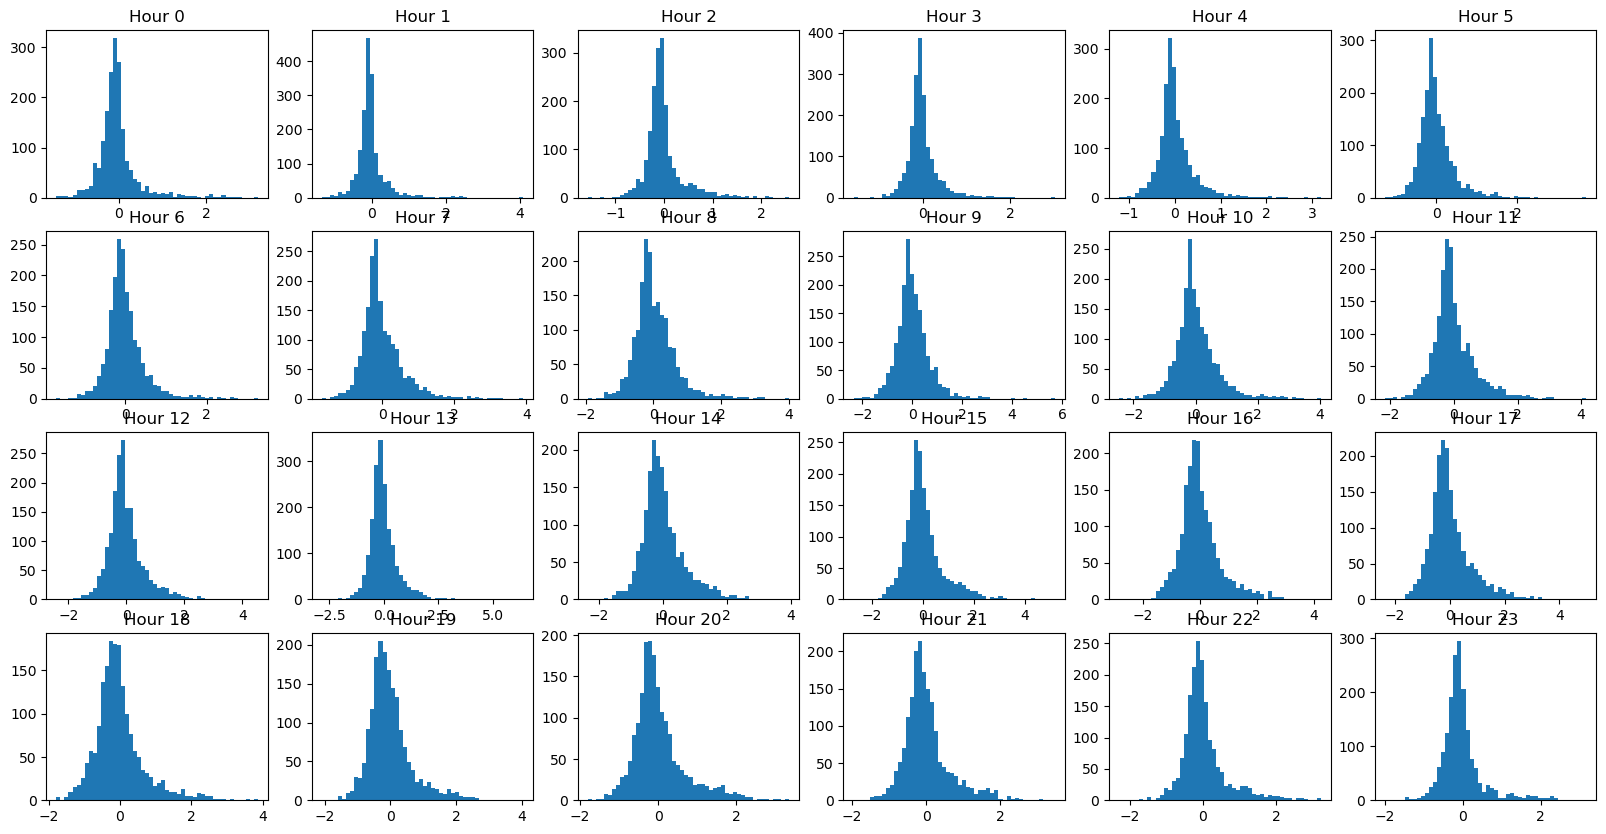

In [54]:
# plot distribution of errors depending on the hour
fig, ax = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        ax[i, j].hist(errors_df.loc[errors_df['Hour'] == 6*i+j, 'net_target+1'], bins=50)
        ax[i, j].set_title(f'Hour {6*i+j}')

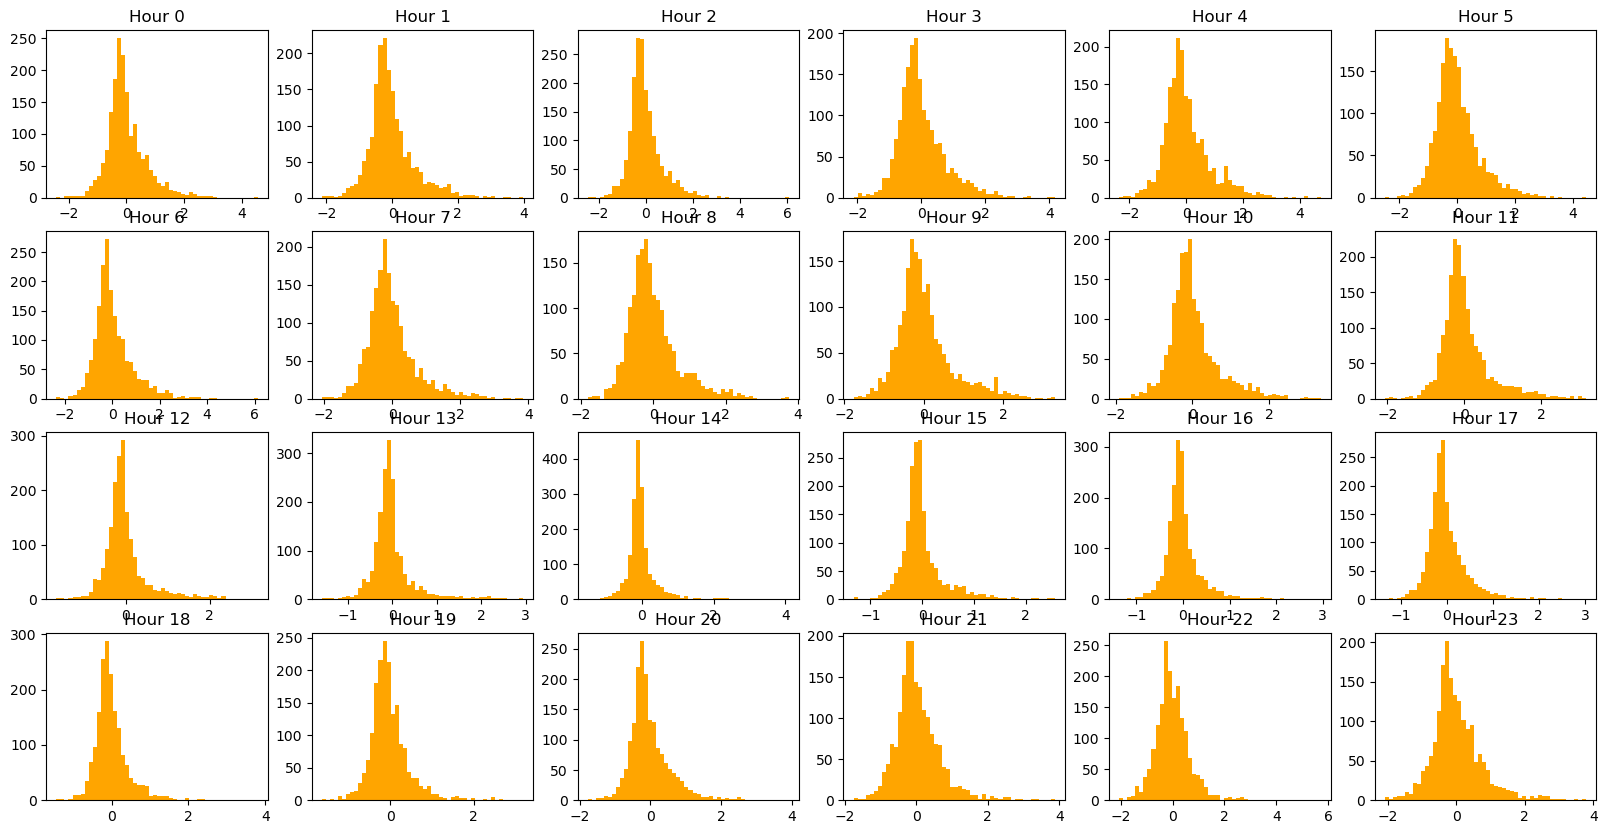

In [59]:
# plot distribution of errors depending on the hour
fig, ax = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        ax[i, j].hist(errors_df.loc[errors_df['Hour'] == 6*i+j, 'net_target+12'], bins=50, color='orange')
        ax[i, j].set_title(f'Hour {6*i+j}')

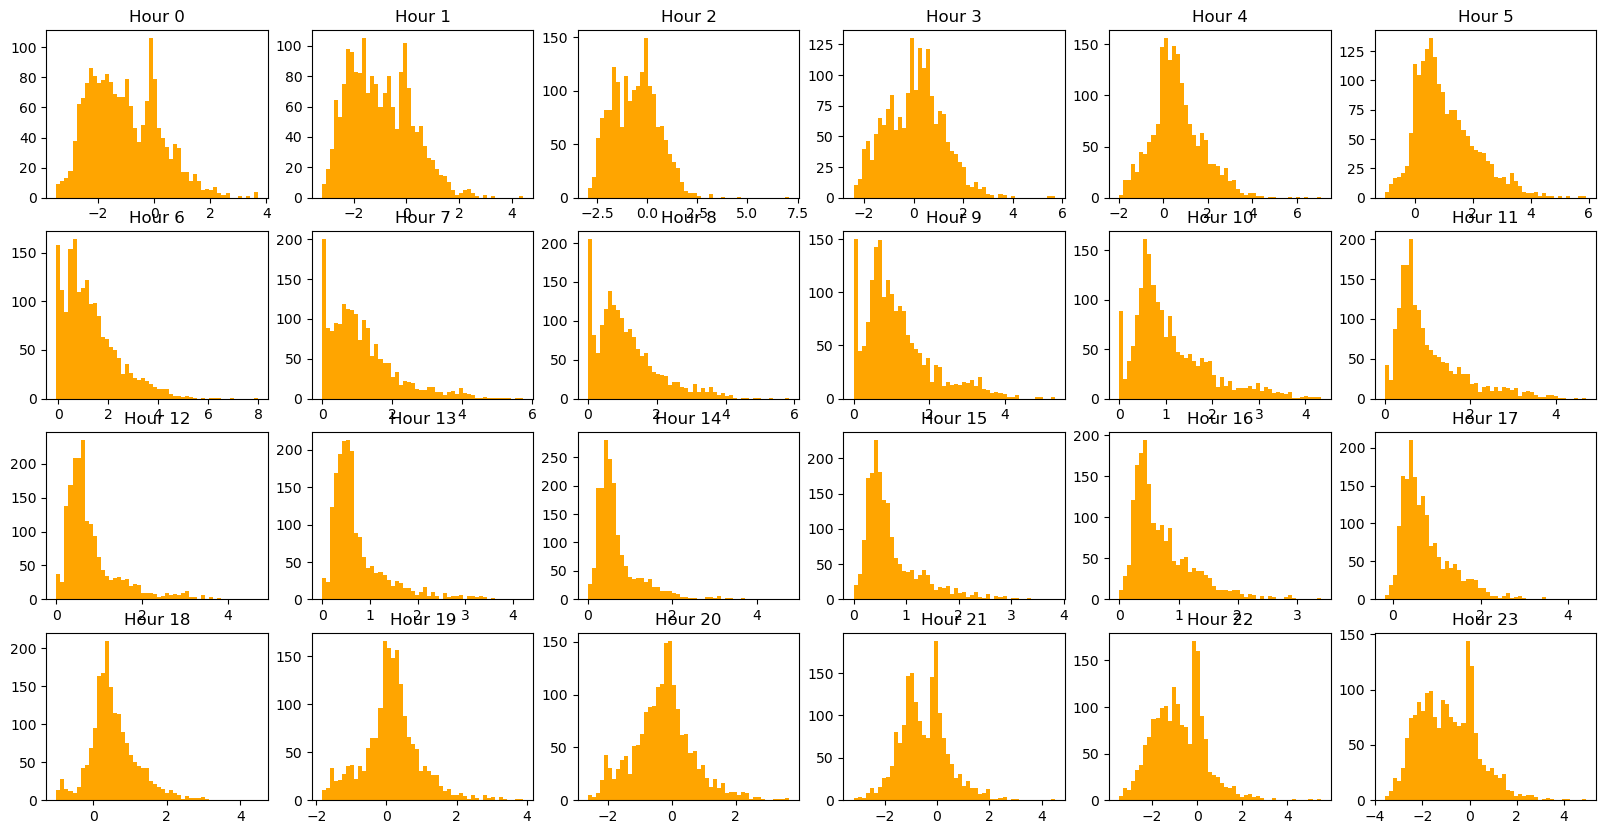

In [68]:
# plot distribution of errors depending on the hour
fig, ax = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        ax[i, j].hist(power_norm.loc[power_norm['Hour'] == 6*i+j, 'net_target+12'], bins=50, color='orange')
        ax[i, j].set_title(f'Hour {6*i+j}')

In [79]:
from scipy.stats import norm, uniform
tail_high = .1
n_samples = 100
dist = norm(loc=0, scale=2)
tail_rvs = dist.ppf(uniform.rvs(0, tail_high, n_samples))

(array([2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 2., 1., 3., 0., 0., 1., 3., 1., 2., 0., 1., 4., 1., 2., 2.,
        2., 2., 5., 3., 7., 4., 6., 3., 5., 1., 4., 7., 2., 6., 6., 6.]),
 array([-6.39169116, -6.31517645, -6.23866173, -6.16214702, -6.0856323 ,
        -6.00911758, -5.93260287, -5.85608815, -5.77957344, -5.70305872,
        -5.626544  , -5.55002929, -5.47351457, -5.39699986, -5.32048514,
        -5.24397042, -5.16745571, -5.09094099, -5.01442628, -4.93791156,
        -4.86139684, -4.78488213, -4.70836741, -4.6318527 , -4.55533798,
        -4.47882326, -4.40230855, -4.32579383, -4.24927912, -4.1727644 ,
        -4.09624968, -4.01973497, -3.94322025, -3.86670554, -3.79019082,
        -3.7136761 , -3.63716139, -3.56064667, -3.48413196, -3.40761724,
        -3.33110252, -3.25458781, -3.17807309, -3.10155838, -3.02504366,
        -2.94852894, -2.87201423, -2.79549951, -2.7189848 , -2.64247008,
        -2.56595536]),
 <BarContainer object

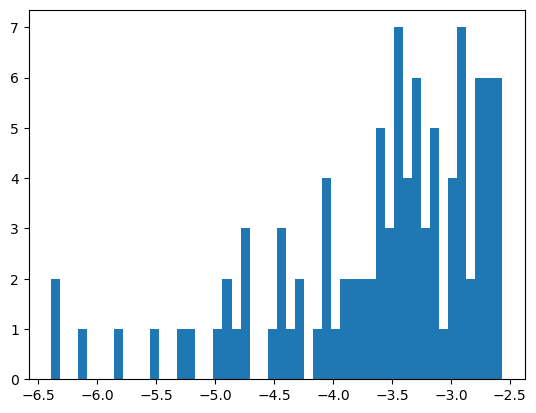

In [80]:
# plot tail_rvs
plt.hist(tail_rvs, bins=50)

In [63]:
# estimate standard deviation of errors for each hour for each lead time into a dictionary of dictionaries of the format std_dict[hour][lead_time]
std_dict = {}
lead_times = ['net_target+'+str(i) for i in range(24)]
for hour in range(24):
    std_dict[hour] = {}
    for i, lead_time in enumerate(lead_times):
        std_dict[hour][i] = np.std(errors_df.loc[errors_df['Hour'] == hour, lead_time])

In [65]:
# estimate standard deviation of real_power for each hour for each lead time into a dictionary of dictionaries of the format std_dict[hour][lead_time]
std_dict_real_power = {}
lead_times = ['net_target+'+str(i) for i in range(24)]
for hour in range(24):
    std_dict_real_power[hour] = {}
    for i, lead_time in enumerate(lead_times):
        std_dict_real_power[hour][i] = np.std(power_norm.loc[power_norm['Hour'] == hour, lead_time])

In [64]:
# save std_dict to models/error_sim/std_dict_hour_leadtime.pkl
with open('models/error_sim/std_dict_hour_leadtime.pkl', 'wb') as f:
    pkl.dump(std_dict, f)

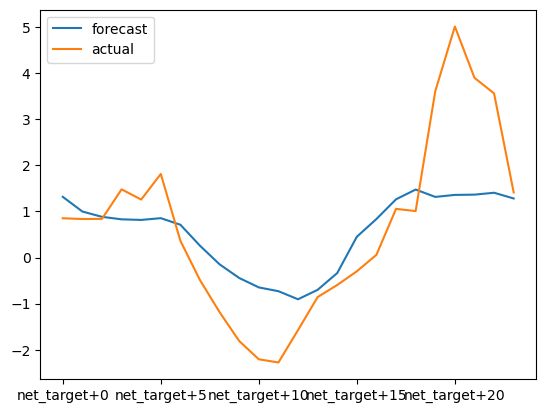

In [27]:
forecs.loc[0, 0].plot(label='forecast')
power_norm.loc[0, 0].plot(label='actual')
plt.legend()
plt.show()